In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
original_df = pd.read_csv("../data/training_data.csv")
submission = pd.read_csv("../data/data_submission_example.csv")

In [66]:
df = original_df.copy()

In [67]:
min = df["CONTRACT_DATE_OF_LOAN_AGREEMENT"].min()

df["CONTRACT_DATE_OF_LOAN_AGREEMENT"] = (
    df["CONTRACT_DATE_OF_LOAN_AGREEMENT"] - min
)
df["TARGET_EVENT_DAY"] = df["TARGET_EVENT_DAY"] - min

<Axes: >

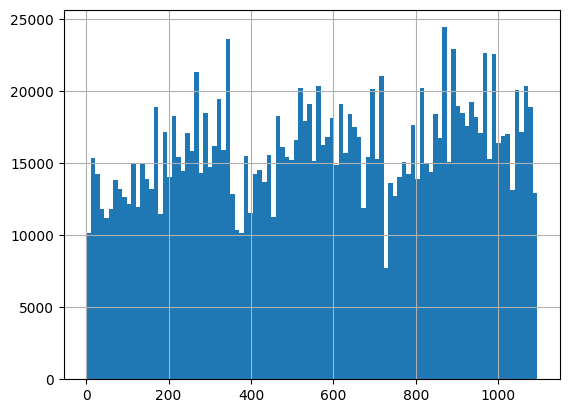

In [68]:
df["CONTRACT_DATE_OF_LOAN_AGREEMENT"].hist(bins=100)

<Axes: >

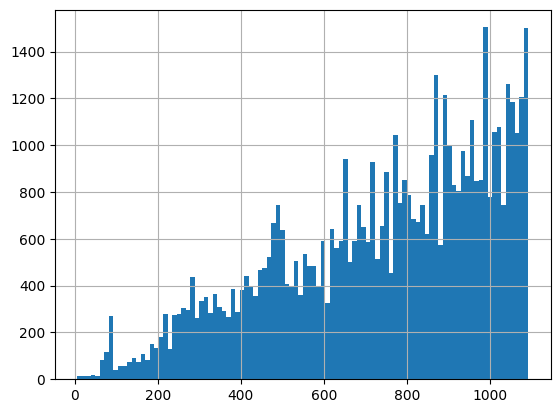

In [69]:
df["TARGET_EVENT_DAY"].hist(bins=100)

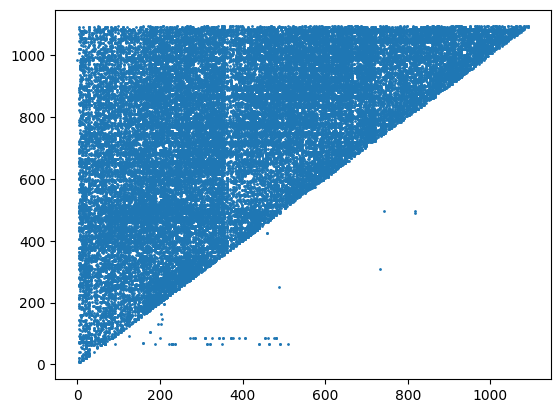

In [70]:
plt.scatter(df["CONTRACT_DATE_OF_LOAN_AGREEMENT"], df["TARGET_EVENT_DAY"], s=1)

<Axes: >

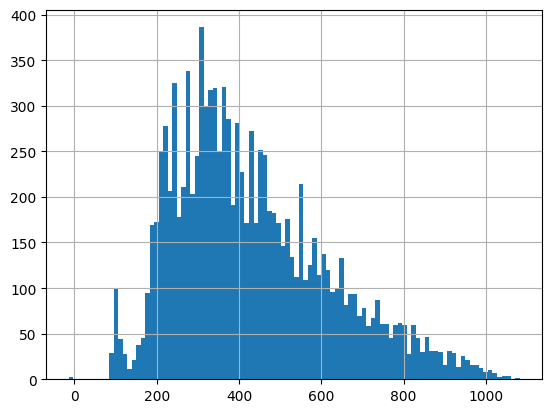

In [71]:
bedoltek = df[df["TARGET_EVENT"] == "K"].copy()
bedoltek["Meddig birta"] = bedoltek["TARGET_EVENT_DAY"] - bedoltek["CONTRACT_DATE_OF_LOAN_AGREEMENT"]
bedoltek["Meddig birta"].hist(bins=100)

# ModeA terv

- Első 365 nap adataiból készítek tanító adathalmazt célváltozóval -> R1 adathalmaz
- Az utolsó 365 nap adataiból ugyenezt, de ott nem lesz élrtelmes célváltozó -> R2 adathalmaz
- Modellt építek R1-en, optimalizálom, javítgatom, majd alkalmazom a beküldőn R2 adathalmazon

In [72]:
def datagen_modeA(original_df, start_day, end_day):
    df = original_df[
        (original_df["CONTRACT_DATE_OF_LOAN_AGREEMENT"] >= start_day)
        & (original_df["CONTRACT_DATE_OF_LOAN_AGREEMENT"] < end_day)
    ].copy()
    customer_df = pd.DataFrame({"BORROWER_ID": df["BORROWER_ID"].unique()})

    # Target valtozo keszitese
    feltetel = (
        (df["TARGET_EVENT_DAY"] >= end_day)
        & (df["TARGET_EVENT_DAY"] < end_day + 2 * 365)
        & (original_df["TARGET_EVENT"] == "K")
    )
    df["target"] = 0
    df.loc[feltetel, "target"] = 1
    stat = df.groupby("BORROWER_ID", as_index=False).agg({"target": "max"})
    customer_df = customer_df.merge(stat, on="BORROWER_ID", how="left")
    customer_df["target"].fillna(0, inplace=True)

    # Bemeno valtozok
    stat = df.groupby("BORROWER_ID", as_index=False).agg(
        {"CONTRACT_ID": "count", "CONTRACT_LOAN_AMOUNT": "sum"}
    )
    stat.columns = ["BORROWER_ID", "in_contract_num", "in_loan_amount_sum"]
    customer_df = customer_df.merge(stat, on="BORROWER_ID", how="left")
    return customer_df


R1 = datagen_modeA(df, 0, 365)
R2 = datagen_modeA(df, 2 * 365, 3 * 365)

In [73]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

In [74]:
R1 = R1.reset_index(drop=True)
cv = 2
bemeno_valtozok = ["in_contract_num", "in_loan_amount_sum"]
loglosslist = []
R1["fold"] = R1.index % cv
for i in range(cv):
    train_df = R1[R1["fold"] != i].copy()
    test_df = R1[R1["fold"] == i].copy()
    gbm = GradientBoostingClassifier()
    gbm.fit(train_df[bemeno_valtozok], train_df["target"])
    test_df["pred"] = gbm.predict_proba(test_df[bemeno_valtozok])[:, 1]
    logloss = log_loss(test_df["target"], test_df["pred"])
    print(i, logloss)
    loglosslist.append(logloss)
print("Atlagos logloss:", np.mean(loglosslist))

0 0.060316843743272515
1 0.06116430625965047
Atlagos logloss: 0.06074057500146149


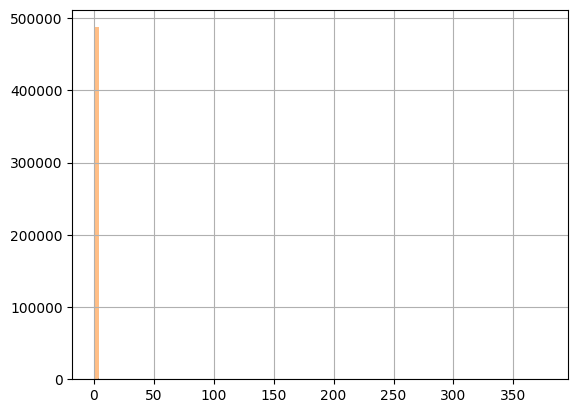

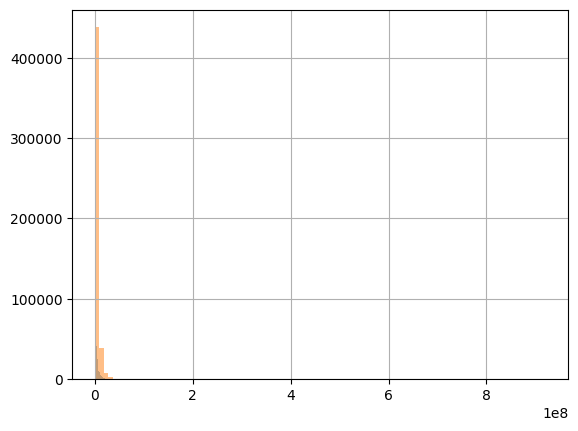

In [75]:
r1 = R1[R1["in_contract_num"] < 10].copy()
for v in bemeno_valtozok:
    r1[v].hist(bins=100, alpha=0.5)
    R2[v].hist(bins=100, alpha=0.5)
    plt.show()

In [76]:
gbm.fit(R1[bemeno_valtozok], R1["target"])
R2["p"] = gbm.predict_proba(R2[bemeno_valtozok])[:, 1]

<Axes: >

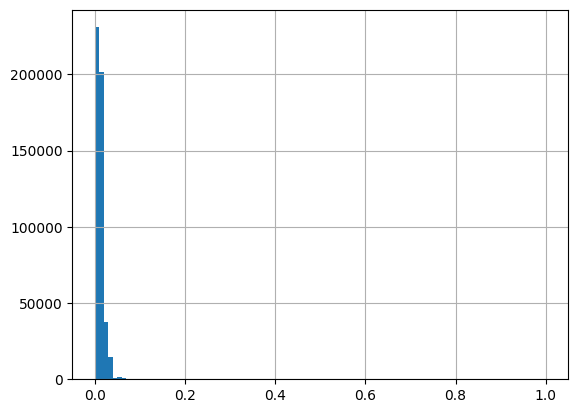

In [77]:
R2["p"].hist(bins=100)

In [80]:
submission2 = submission.merge(R2[["BORROWER_ID", "p"]], on="BORROWER_ID", how="left")
submission2.loc[~submission2["p"].isna(), "pred"] = submission2.loc[~submission2["p"].isna(), "p"]

del submission2["p"]
submission2.to_csv("../data/data_submission_1.csv", index=False)

In [82]:
R2["p2"] = 1 - R2["p"]
R2["p2"].mean() # 1 - 0.0148
R2["p2"] = R2["p2"] * (1 - 0.0148) / R2["p2"].mean()
R2["p3"] = 1 - R2["p2"]
R2["p3"].describe()

count    487907.000000
mean          0.014800
std           0.022077
min           0.003472
25%           0.005390
50%           0.014832
75%           0.020290
max           1.000000
Name: p3, dtype: float64

In [ ]:
submission2 = submission.merge(R2[["BORROWER_ID", "p3"]], on="BORROWER_ID", how="left")
submission2.loc[~submission2["p3"].isna(), "pred"] = submission2.loc[~submission2["p3"].isna(), "p3"]

del submission2["p3"]
submission2.to_csv("../data/data_submission_2.csv", index=False)